# Project-1: Cats and Dogs Classifier using Logistic Regression

In this project we'll be building a `Dog and Cat classifier` from scratch using `Logistic Regression` from `scikit-learn` library. For some supplementary information about this project, refer to the 4th article of [Demystifying Machine Learning](https://swayam-blog.hashnode.dev/series/demystifying-ml) series.

In this tutorial we'll be more focussing towards

    - How to gather data ?
    - How to pre-process data for training purpose
    - How to label the images as `cat` or `dog` for training purpose
    - How to create training and testing sets

And in the last we'll use our pre-processed data to train our logistic regression model. I'll show you how easy it is to train machine learning algorithms using `scikit-learn` library which already contain wrappers for many ML algorithms.


## 1. Important packages
- `requests`: for downloading the compressed (zipped) dataset.
- `zipfile`: for extracting the dataset.
- `os`: for getting path and file names from system
- `PIL`: for applying image transformations on images
- `matplotlib`: for displaying images and graphs
- `numpy`: for array manipulations
- `sklearn`: library containing wrappers for ML algorithms
- `seaborn`: for plotting heatmaps

In [1]:
# importing useful libraries

import requests
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

np.random.seed(42)

## 2. Helper functions
Below are some helper functions for this notebook to make some work easier.

- `download`: to download the compressed version of dataset directly from this notebook
- `extract_zip`: to extract the zipped file
- `center_crop`: to crop any image from center about the given size

In [2]:
def download(url, file_name):
  """
  Downloads the dataset for project
  input:
    url (string): url for dataset
    file_name (string): file name in which downloaded dataset will be stored
  """
  response = requests.get(url, stream=True)
  if response.status_code == 200:
      with open(file_name, 'wb') as f:
          f.write(response.raw.read())

In [3]:
def extract_zip(s_path, d_path):
  """
  Extract (unzip) the compressed dataset for working
  input:
    s_path (string): path of zipped dataset
    d_path (string): path to store the unzipped dataset
  """
  with zipfile.ZipFile(s_path, 'r') as zip_ref:
      zip_ref.extractall(d_path)

In [4]:
def center_crop(image_path, size):
  """
  crop the image from center of the given size
  input:
    image_path (string): Path of image
    size (int): size to which the image being cropped from center
  """
  img = Image.open(image_path)
  img = img.resize((size+1,size+1))
  x_center = img.width/2
  y_center = img.height/2
  size = size/2
  cr = img.crop((x_center-size, y_center-size, x_center+size, y_center+size))

  return cr

### 2.1 downloading and extracting dataset

In [5]:
download("https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip", "images.zip")

In [6]:
extract_zip("images.zip", "images")

## 3. Dislpaying an image just for verification of dataset

- `Image.open()`: takes the path of image and gives an `JpegImageFile` object, through which we can plot it
- `plt.imshow()`: takes that `JpegImageFile` object and plot the image as a graph

In [7]:
img = Image.open("./images/Cat_Dog_data/train/cat/cat.0.jpg")
img.format, type(img)

('JPEG', PIL.JpegImagePlugin.JpegImageFile)

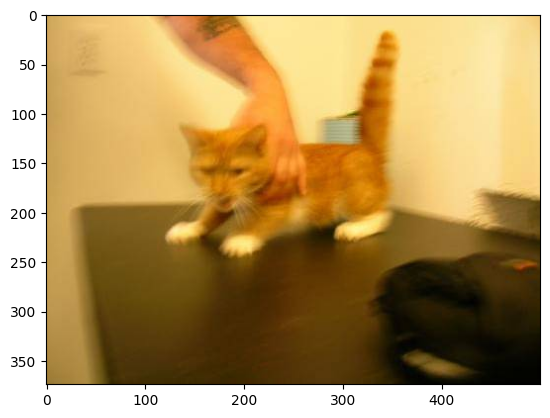

In [8]:
plt.imshow(img)

## 4. Grabbing all the names of cats and dogs images
In this section, we take all the names of cats and dogs images and save them into two separate lists.

`os.listdir()` function takes the path of folder and returns a list containing the names of lists and directories inside that folder.

Here we are taking the name of all images from the training images of cats and dogs.
> Training images are inside the folder `Cat_Dog_data/train`

In [9]:
cat_list = os.listdir("./images/Cat_Dog_data/train/cat")
dog_list = os.listdir("./images/Cat_Dog_data/train/dog")

We are only taking 6000 images from each category for training and reducing the computation time. You can take all if you want.

> You may not feel good when taking entire data, because logistic regression is not that good with such large number of features. In future we'll learn Neural networks that will give remarkable results even with much large number of features

In [10]:
cat_list = cat_list[:7000]
dog_list = dog_list[:7000]

In [11]:
len(cat_list), len(dog_list)

(7000, 7000)

Here we are creating a new list to contain the names of both cats and dogs so that we can shuffle them instead of keeping cat images in top and dogs in bottom

- `.extend()` is a `list` method that append itmes of an entire list in the end of another list
- `np.random.shuffle()` takes the list/array and randomly shuffle it's elements

In [12]:
train_list = []
train_list.extend(cat_list)
train_list.extend(dog_list)

In [13]:
np.random.shuffle(train_list)

In [14]:
## shuffled version of `train_list`
train_list[:10]

['cat.928.jpg',
 'cat.3859.jpg',
 'dog.1789.jpg',
 'cat.11336.jpg',
 'dog.11956.jpg',
 'dog.6150.jpg',
 'dog.10648.jpg',
 'dog.508.jpg',
 'dog.7415.jpg',
 'cat.9499.jpg']

## 5. Preparing Training data
In this section we'll use the `train_list` that contains the names of all training images and we convert those images into numpy array because our logistic regression only works on numbers not any `.jpg` file so we store them inside the `train_data` (a numpy array) so that our model can learn from them.

We had 7000 images of cats and dogs each that means we had total 14,000 images. But all these images have different shapes like height and width, so we need to crop them into a fix size so that our model can easily learn from them by specifying requied weights.

We are going to crop each image into 100x100 size and since they are RGB images so the final shape of each of our image will be 100x100x3

**Step 1:** we will be creating an array name as `train_data` that will contain all zeros, then later we'll be assigning all the images into each row of this array

`np.zeros((14000, 100*100*3))`: creates an array of (14000, 30000) shape with all 0s

In [15]:
train_data = np.zeros((14000,100*100*3))

**Step 2**: iterating through `train_list` and cropping each image from center in 100x100 size, then converting `PIL` object into numpy array and storing it into `train_data`

- Do not forget to flatten the image using `.reshape(-1)`. So that we can store it into `train_data`.

> all the 100x100x3 values will act as features and number of images will be total number of samples in dataset.

In [16]:
for i, image_name in enumerate(train_list):
  if image_name.split(".")[0] == "dog":
    path =  "./images/Cat_Dog_data/train/dog"
  else:
    path =  "./images/Cat_Dog_data/train/cat"
  image_path = f'{path}/{image_name}'
  crp_img = center_crop(image_path,100)
  crp_arr = np.array(crp_img).reshape(-1)
  train_data[i] = crp_arr

In [17]:
train_data[0]

array([ 80.,  81.,  67., ..., 155., 154., 154.])

**Step 3:**: Scaling array values between 0 and 1 so that our algorithm can converge nicely.

We know that value of any pixel can range between 0-255 so if we divide all the elements by 255 then it'll scale them between 0-1

In [18]:
train_data = train_data/255

In [19]:
train_data[0]

array([0.31372549, 0.31764706, 0.2627451 , ..., 0.60784314, 0.60392157,
       0.60392157])

### 5.2 Preparing label data

Now our training data is ready. The only thing remains is to provide labels for our training set so that our algorithm can learn which image is cat and which one is dog.

We'll be denoting:

    - `cat` as 0
    - `dog` as 1

We can loop through `train_list` and check if their name contains word `cat` then mark that image as cat otherwise dog

for example let's take a sample image:

**cat.8133.jpg**

we can see that if we somehow manage to grab the word before 1st '.' and check it for `cat` or `dog` then we can label that specific image

- `split()`: is a `list` method which takes a character as input and split the string from given character into a string

In [20]:
print("printing the name of some image")
print("-> ",train_list[0])
print("Splitting the image from all . characters into a list")
print("-> ",train_list[0].split("."))
print("selecting the 0th element of splitted list")
print("-> ",train_list[0].split(".")[0])

printing the name of some image
->  cat.928.jpg
Splitting the image from all . characters into a list
->  ['cat', '928', 'jpg']
selecting the 0th element of splitted list
->  cat


Now we can use the same above technique to check whether name contains the word `cat` or `dog` and label that sample as 0 and 1 respectively

In [21]:
# cat: 0
# dog: 1
train_labels = np.array([0 if name.split(".")[0]=="cat" else 1 for name in train_list])

In [22]:
train_labels.shape

(14000,)

## 6. Training Logistic Regression model
In this section we'll be using `sklearn` library to use `LogisticRegression` for training a model and you'll how easy it'll be

`LogisticRegression` class lies inside `sklearn.linear_model`, you can learn more about it from the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Now create an instance of it's by passing various hyperparameters like:

- `max_iter`: number of epochs
- `solver`: which solving algo to use
- `n_jobs`: number of CPU cores to use for parallel computation

> for tutorial purpose and fast computation I'm setting max_iter = 100, but you can set it to some large value for better result

In [23]:
model = LogisticRegression(max_iter=300, n_jobs=-1)

now just train the model by calling `.fit()` method on model and passing `training_data` and `train_labels`

In [24]:
model.fit(train_data, train_labels)

LogisticRegression(max_iter=300, n_jobs=-1)

you can print the accuracy of your model by calling `.score()` method on model by passing data and labels

In [25]:
model.score(train_data, train_labels)

0.8396428571428571

### Predicting an image to see the result
Let's open a random test image from `Cat_Dog_dara/test` folder and use model to see how its classifying it

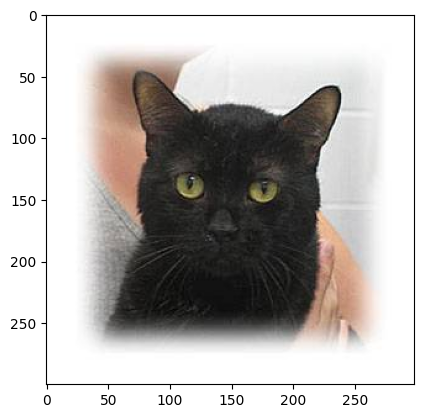

In [26]:
test_img = "./images/Cat_Dog_data/test/cat/cat.10038.jpg"
img = Image.open(test_img)
plt.imshow(img)

> Note: Before predicting you need to convert the sample testing image into the same size as we used while training images i.e. in 100x100x3

In [27]:
im = center_crop(test_img,100) # cropping image
X = np.array(im).reshape(-1) # flattening the image to pass in model for prediction
X = X/255 # scale the pixels in 0-1 range

use `.predict()` method on model by passing array of testing image to get the prediction

if output is:
- 0: cat
- 1: dog

In [28]:
model.predict([X])

array([1])

## Analyzing results on training data using Confusion matrix

Confusion matrix tells us how many samples are correctly classified and how many are incorrectly classified.

We'll be using `sklearn.metrics` to import `confusion_matrix`. `confusion_matrix` takes `preds` and `true labels` as input and returns a matrix.

In [29]:
train_pred = model.predict(train_data)
cm = confusion_matrix(train_pred, train_labels)
cm

array([[5941, 1186],
       [1059, 5814]])

we can better visualize that `confusion_matrix` by a heatmap. `Seaborn` package provide facility to plot heatmaps very easily by passing matrix

After plotting you can verify it as:

    0th row and 0th column :- number denotes the samples that are 0 and also predicted as 0
    0th row and 1th column :- number denotes the samples that are 1 and also predicted as 0
    1th row and 0th column :- number denotes the samples that are 0 and also predicted as 1
    1th row and 1th column :- number denotes the samples that are 1 and also predicted as 1

<Axes: >

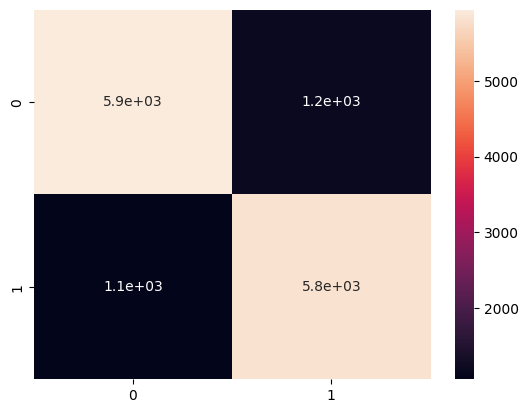

In [30]:
sns.heatmap(cm, annot=True)

## Preparing test data to check performance on unseen samples

Just similar to steps we did for preparing `training data` are going to be taken here too, just the folder for getting image data will be different `Cat_Dog_data/test/`

In [90]:
test_data_cat = os.listdir("./images/Cat_Dog_data/test/cat")
test_data_dog = os.listdir("./images/Cat_Dog_data/test/dog")

only taking 400 test cat images and 400 test dog images

In [103]:
test_data_cat = test_data_cat[:1250]
test_data_dog = test_data_dog[:1250]

In [104]:
test_list = []
test_list.extend(test_data_cat)
test_list.extend(test_data_dog)

In [105]:
len(test_list)

2500

In [111]:
test_data = np.zeros((2500,100*100*3))

In [112]:
for i, image_name in enumerate(test_list):
  if image_name.split(".")[0] == "dog":
    path =  "./images/Cat_Dog_data/test/dog"
  else:
    path =  "./images/Cat_Dog_data/test/cat"
  image_path = f'{path}/{image_name}'
  crp_img = center_crop(image_path,100)
  crp_arr = np.array(crp_img).reshape(-1)
  test_data[i] = crp_arr

In [113]:
test_data = test_data/255

In [114]:
test_labels = np.array([0 if name.split(".")[0]=="cat" else 1 for name in test_list])

## Analyzing results on test data using Confusion matrix

[[697 564]
 [553 686]]


<Axes: >

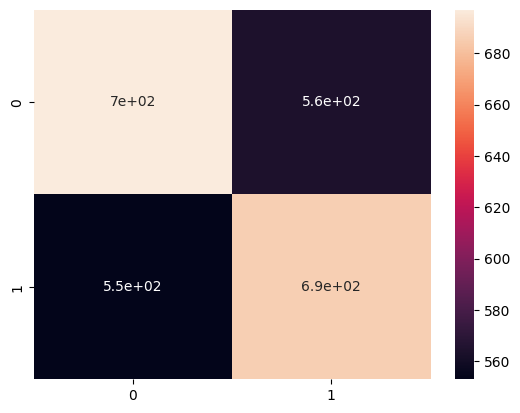

In [115]:
pred = model.predict(test_data)
cm = confusion_matrix(pred, test_labels)
print(cm)
sns.heatmap(cm, annot=True)

In [116]:
test_acc = model.score(test_data, test_labels)
print("Accuracy on test set: ", test_acc)

Accuracy on test set:  0.5532


## Predicting own custom image

In this section, we will learn to pass our own custom images of dogs and cats and let the model predict them

here we have 2 helper functions:

- `show_image`: this function takes the path of image as input and display it
- `predict_custom_image`: this function takes `model` and `image_path` as input and returns the predicted value

In [117]:
def show_image(img_path):
    img = Image.open(img_path)
    plt.imshow(img)

In [118]:
def predict_custom_image(model, img_path):
    crp_img = center_crop(img_path,100)
    crp_arr = np.array(crp_img).reshape(1,-1)
    pred = model.predict(crp_arr)
    if pred == 0:
        return "Cat"
    return "Dog"

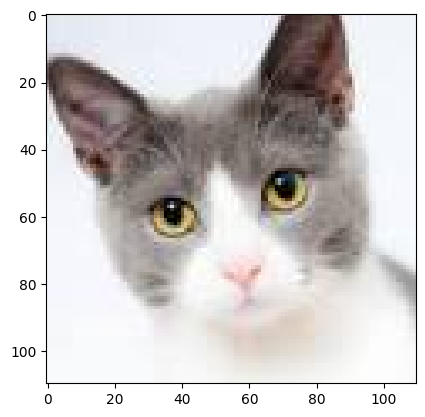

In [119]:
test_img_path = "test.jpg" # provide path to your custom image (make sure it's either jpg or jpeg)
show_image(test_img_path)

In [120]:
predict_custom_image(model, test_img_path)

'Cat'

## **Conclusion**
MADE BY VIDHYAMBIKA